In [70]:

import os
import glob
import numpy
import tifffile
    
from skimage import draw, morphology, measure, filters
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from collections import defaultdict
from matplotlib import pyplot

import sys
sys.path.insert(0, "../../")
from DEFAULTS import COLORS, DATASETS

def read_poly(path, image_shape, class_ids=[0, 3]):
    """
    Reads and creates the labels from the .poly.txt files

    :param path: The path to the .poly.txt file
    :param metadata: The metadata of the images

    """
    label = numpy.zeros((len(class_ids), *image_shape))
    with open(path, "r") as f:
        data = f.readlines()
    data = [x.strip() for x in data]
    for polyid, row in enumerate(data):
        split = row.split(" ")
        z, class_id, coordinates = int(split[0]), int(split[1]), eval(" ".join(split[2:]))
        for i, class_ids_ in enumerate(class_ids):
            if isinstance(class_ids_, int):
                class_ids_ = [class_ids_]
            if class_id not in class_ids_:
                continue

            r, c = [], []
            for coord in coordinates:
                r.append(int(coord[1]))
                c.append(int(coord[0]))
            rr, cc = draw.polygon(r, c, shape=image_shape)
            label[i][rr, cc] = polyid + 1
    return label

In [71]:
MODELS = [
    "NAIVE",
    "Intensity",
    "random-patches",
    "MAE_SMALL_STED",
    "MAE_SMALL_SIM",
    "MAE_SMALL_HPA",
    "MAE_SMALL_JUMP",
    "MAE_SMALL_IMAGENET1K_V1",
]
dataset = "multistructure-factin"
templates = {
    "template-factin-assemblies-jchabbert" : {
        "class-id" : 1
    },
    "template-factin-spine-jchabbert" : {
        "class-id" : [3, 6]
        # "class-id" : [3]
    },
    "template-factin-spots-jchabbert" : {
        "class-id" : 2
    },
}
IMAGEPATH = "/home-local2/projects/SSL/detection-data/"
PREDICTIONPATH = "/home-local2/projects/SSL/results/detection-experiments"

images = glob.glob(os.path.join(IMAGEPATH, dataset, "**/*.tif"))
polytxt = [x.replace(".tif", "_Julia.polys.txt") for x in images]

In [76]:
SHOW = False

scores_per_model = {}
for model in MODELS:
    print(model)
    scores = defaultdict(list)
    for image_name, polytxt_name in zip(images, polytxt):
        image = tifffile.imread(image_name)[0]
        for template_name, template in templates.items():
            folder = image_name.split(dataset)[-1]
            if folder.startswith("/"):
                folder = folder[1:]
            folder = os.path.dirname(folder)

            label = read_poly(polytxt_name, image.shape, class_ids=[template["class-id"]])
            if numpy.any(label):
                label = label>0
                if model == "NAIVE":
                    prediction = measure.block_reduce(label[0]>0, (16, 16), numpy.max)
                    prediction = numpy.repeat(numpy.repeat(prediction, 16, axis=0), 16, axis=1)
                    prediction = prediction[:image.shape[0], :image.shape[1]]
                    # prediction = morphology.binary_dilation(label[0]>0, numpy.ones((2 * 16 + 1, 2 * 16 + 1)))
                    scores[template_name].append((
                        precision_score(label.flatten(), prediction.flatten()),
                        recall_score(label.flatten(), prediction.flatten())
                    ))
                elif model == "random-patches":
                    foreground = image > filters.threshold_otsu(image)
                    foreground = measure.block_reduce(foreground, (16, 16), numpy.mean) > 0.1

                    prediction = measure.block_reduce(label[0]>0, (16, 16), numpy.max)
                    h, w = prediction.shape

                    num_repeats = 10
                    pred_within_foreground = prediction.ravel()[foreground.ravel()]
                    precision, recall = 0, 0
                    for _ in range(num_repeats):
                        permutted_foreground = numpy.random.permutation(pred_within_foreground)

                        pred = numpy.zeros(h * w)
                        pred[foreground.ravel()] = permutted_foreground
                        pred = numpy.repeat(numpy.repeat(pred.reshape(h, w), 16, axis=0), 16, axis=1)
                        pred = pred[:image.shape[0], :image.shape[1]]

                        precision += precision_score(label.flatten(), pred.flatten())
                        recall += recall_score(label.flatten(), pred.flatten())
                                            
                    scores[template_name].append((
                        precision / num_repeats,
                        recall / num_repeats
                    ))
                elif model == "Intensity":
                    prediction = image
                    precision, recall, _ = precision_recall_curve(label.flatten(), prediction.flatten())
                    scores[template_name].append(numpy.interp(numpy.linspace(0, 1, 100), recall[::-1], precision[::-1]))
                else:
                    prediction = tifffile.imread(
                        os.path.join(PREDICTIONPATH, model, template_name, dataset, folder, os.path.basename(image_name))
                    )[1] # first channel is the image, second channel is the prediction

                    if SHOW and "assemblies" in template_name:
                        fig, ax = pyplot.subplots()
                        ax.imshow(image, cmap="gray", vmax=numpy.quantile(image, 0.99))
                        ax.set(title=f"{image_name} - {template_name}")
                        ax.imshow(label[0], alpha=0.3)
                        ax.imshow(prediction, alpha=0.3, cmap="magma", vmin=numpy.quantile(prediction, 0.75))
                        pyplot.show()

                    precision, recall, _ = precision_recall_curve(label.flatten(), prediction.flatten())
                    scores[template_name].append(numpy.interp(numpy.linspace(0, 1, 100), recall[::-1], precision[::-1]))

    scores_per_model[model] = scores
            

NAIVE
Intensity
random-patches
MAE_SMALL_STED
MAE_SMALL_SIM
MAE_SMALL_HPA
MAE_SMALL_JUMP
MAE_SMALL_IMAGENET1K_V1


template-factin-assemblies-jchabbert
NAIVE (40, 2)
Intensity (40, 100)
random-patches (40, 2)
MAE_SMALL_STED (40, 100)
MAE_SMALL_SIM (40, 100)
MAE_SMALL_HPA (40, 100)
MAE_SMALL_JUMP (40, 100)
MAE_SMALL_IMAGENET1K_V1 (40, 100)


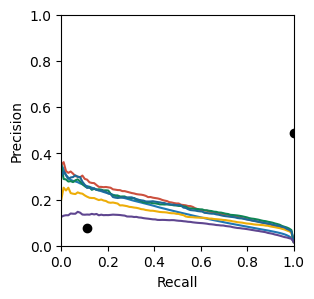

template-factin-spine-jchabbert
NAIVE (47, 2)
Intensity (47, 100)
random-patches (47, 2)
MAE_SMALL_STED (47, 100)
MAE_SMALL_SIM (47, 100)
MAE_SMALL_HPA (47, 100)
MAE_SMALL_JUMP (47, 100)
MAE_SMALL_IMAGENET1K_V1 (47, 100)


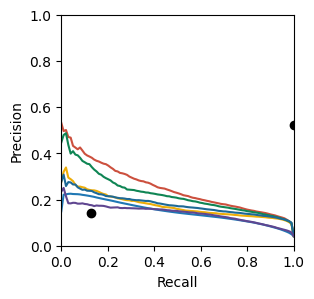

template-factin-spots-jchabbert
NAIVE (43, 2)
Intensity (43, 100)
random-patches (43, 2)
MAE_SMALL_STED (43, 100)
MAE_SMALL_SIM (43, 100)
MAE_SMALL_HPA (43, 100)
MAE_SMALL_JUMP (43, 100)
MAE_SMALL_IMAGENET1K_V1 (43, 100)


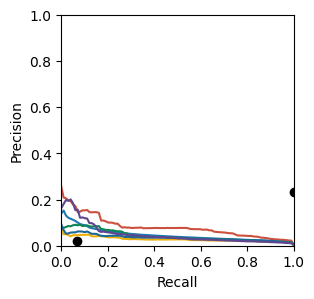

In [ ]:
recall = numpy.linspace(0, 1, 100)
for template in templates.keys():
    fig, ax = pyplot.subplots(figsize=(3, 3))
    for model, scores in scores_per_model.items():
        precisions = numpy.array(scores[template])
        print(model, precisions.shape)
        if precisions.shape[-1] != len(recall):
            p, r = numpy.mean(precisions, axis=0)
            ax.scatter(r, p, color="black")
        else:
            mean = numpy.mean(precisions, axis=0)
            ax.plot(recall, mean, color=COLORS[model])

    ax.set(
        ylim=(0, 1.0), xlim=(0, 1),
        ylabel="Precision", xlabel="Recall",
    )
    pyplot.show()

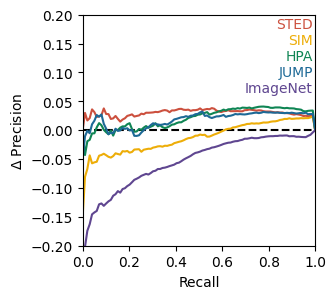

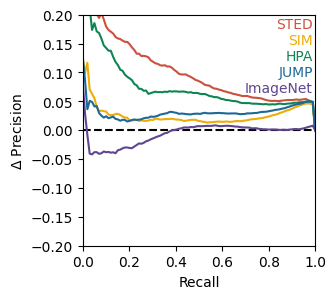

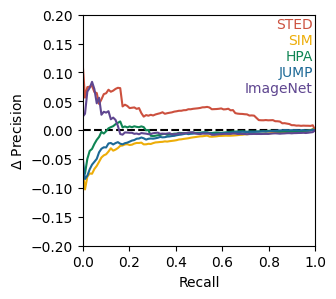

In [64]:
# improvement compared to intensity
recall = numpy.linspace(0, 1, 100)
for template in templates.keys():

    fig, ax = pyplot.subplots(figsize=(3, 3))
    n = 0
    for model, scores in scores_per_model.items():
        baseline = numpy.mean(scores_per_model["Intensity"][template], axis=0)
        if model in ["Intensity", "NAIVE"]:
            continue

        precisions = numpy.array(scores[template])
        mean = numpy.mean(precisions, axis=0)
        mean = mean - baseline
        ax.plot(recall, mean, color=COLORS[model])

        ax.annotate(DATASETS[model], (0.99, 0.99-n*0.07), color=COLORS[model], xycoords="axes fraction", ha="right", va="top")
        n += 1
    ax.axhline(y=0, color="black", linestyle="--", zorder=-1)
    ax.set(
        ylim=(-0.2, 0.2), xlim=(0, 1),
        ylabel=r"$\Delta$ Precision", xlabel="Recall",
    )
    pyplot.show()